# 10/02/23 - Copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/092823_jam_milestone_anisotropy_studies_scratchpad.ipynb
## This is to make the clean script.

#### 09/28/23 - Copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/091323_jam_milestone_anisotropy_studies.ipynb
##### Following meeting with Michele and Tommaso, I am redoing the models with small changes: (JAM has been updated)
###### 1. STILL NOT IMPLEMENTED -q_intr_min (being the intrinsic flattening of the flattest gaussian) is > 0.6
###### 2. Longer chain - 200 iterations?
###### 3. STILL NOT IMPLEMENTED - Plot the convergence of the chain.
###### 4. STILL NOT IMPLEMENTED -Save a value that states if the chain converged.
###### 5. NO OM CYL.
###### 6. Forget the shape distribution from population for J1204 (for consistency's sake)
###### 7. Use "logistic" keyword for OM.
###### 8. Show effective radius in plots
________________
#### 09/21/23 - Edited
##### I messed up the bounds for the constant anisotropy again.
##### It has been fixed, and the prior information has been put into the "get_priors_and_labels" function, which was renamed from "get_priors"
#### 09/13/23  -Copied from 091123_jam_milestone_anisotropy_studies.ipynb
##### I had the anisotropy radius for OM with bounds from the constant anisotropy.

#### 09/11/23 - Copied from 090623_jam_milestone_anisotropy_studies.ipynb
##### I had the Vrms error incorrectly saved. This is a really insane thing.

#### 09/06/23 - Milestone studies for anisotropy constraints. For as many as I can make good models...  4 models each
##### Spherical and Axisymmetric
##### PL mass profile
##### OM and constant anisotropy


#### 05/19/23 - Copied from 012523_jam_bayes.ipynb. Testing the new implementation of anisotropy profiles from Michele. See https://mail.google.com/mail/u/0/?tab=rm&ogbl#search/osipkov/FMfcgzGrcFfBKDBKxwlvtkWlVRXdvklX
#### 05/22/23 - Corrected the "details_for_jampy.pkl" - ONLY FOR J0037 SN 15 so far
- surface brightness is now correctly computed from B-mag (I think)
- bin x and y coordinates rotated along the photometric axis are now correct (phot maj axis is x axis)

#### 05/25/23 - Starting a new notebook just to keep things cleaner.
#### 05/30/23 - Trying to improve things... See
https://mail.google.com/mail/u/0/?tab=rm&ogbl#sent/KtbxLwgddjZLmPGGgmbJhZRvDWrPbJPXpL
#### Today I'm going to try to implement it with emcee instead of adamet
#### 06/02/23 - Running AdaMet and Emcee with corrected photometry.
#### 06/07/23 - Copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/060623_jam_bayes_emcee_pl_const_5obj.ipynb
#### 06/09/23 - Copied from home/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/060723_jam_whole_story_J1204.ipynb
#### 06/13/23 - Actually doing the Einstein radius mass scaling
#### This notebook goes through tests on just J1204 to prepare a "whole story" for the Otranto conference.
#### Power law and composite, spherical and cylindrical, const and OM, SN 15
#### Introducing new methods for incorporating the MSD and mass scaling.
#### Mass scaling will be from the Einstein radius now.
#### I will now work with convergences and multiply by the critical density to get the surface brightness.
#### That is where the proper units come in.
#### 08/10/23 - Changing the break radius and mass sheet radius to check its effect.
##### Make sure const ani parameter [0,1] for cylindrical.
##### Save chi2 of bestfit model and look at distribution (model comparison, BIC, something with evidence comparison)
## 09/06/23 - copied from 081023_jam_J1204_f2f.ipynb
## Milestone studies for anisotropy constraints. For as many as I can make good models...  4 models each
## Spherical and Axisymmetric
## PL mass profile
## OM and constant anisotropy

In [464]:
################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
from pathlib import Path
import pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import astropy.units as u
import astropy.constants as constants

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized

# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.jam_sph_proj import jam_sph_proj
from jampy.mge_half_light_isophote import mge_half_light_isophotehome/shawnknabel/Documents/slacs_kinematics/jupyter_notebooks/jampy/nohup_100223_jam_milestone.txt
from plotbin.plot_velfield import plot_velfield
#from plotbin.sauron_colormap import register_sauron_colormap
#register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa
#from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_radial_mass import mge_radial_mass
from plotbin.symmetrize_velfield import symmetrize_velfield

# adamet
#from adamet.adamet import adamet
from adamet.corner_plot import corner_plot
# emcee
import emcee
import corner
from IPython.display import display, Math

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
#from slacs_ani_mass_jam import osipkov_merritt_model
#from slacs_ani_mass_jam import osipkov_merritt_generalized_model
#from slacs_ani_mass_jam import inner_outer_anisotropy_model
#from slacs_ani_mass_jam import nfw_generalized_model
#from slacs_ani_mass_jam import dark_halo_mge
#from slacs_ani_mass_jam import total_mass_mge
#from slacs_ani_mass_jam import jam_lnprob
#from slacs_ani_mass_jam import jam_lnprob_power_law
#from slacs_ani_mass_jam import jam_lnprob_nfw_constbeta
#from slacs_ani_mass_jam import jam_lnprob_nfwgen_constbeta
#from slacs_ani_mass_jam import jam_lnprob_nfw_om
#from slacs_ani_mass_jam import jam_lnprob_nfwgen_om
#from slacs_ani_mass_jam import summary_plot
#from slacs_ani_mass_jam import save_fit_parameters
#from slacs_ani_mass_jam import get_power_law_slope
#from slacs_ani_mass_jam import jampy_details
#from slacs_ani_mass_jam import prepare_to_jam
#from slacs_ani_mass_jam import space_jam
#from slacs_mge_jampy import make_gaussian

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC
# B band (F435W) dust extinction ~ 0.116 from https://irsa.ipac.caltech.edu/applications/DUST/
#extinction = 0.116
### photometric zeropoint for F435W as of 2007 was 25.745
#photometric_zeropoint = 25.745
# redshift, convert to angular diameter dist in Mpc
#z = 0.195
#distance = cosmo.angular_diameter_distance(z).value

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


In [270]:
##################################################################################################################################

date_of_kin = '2023-02-28_2'

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'
# create a directory for JAM outputs
#Path(jam_output_dir).mkdir(parents=True, exist_ok=True)
#print(f'Outputs will be in {jam_output_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_051223.csv')
slacs_ix_table = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
zs = paper_table['zlens']
zlenses = slacs_ix_table['z_lens']
zsources = slacs_ix_table['z_src']

# Lensing details from Anowar Shajib 2020

In [271]:
# power law info

lens_models = pd.read_csv(f'{tables_dir}lens_models_table.csv')


In [272]:
# class to collect and save all the attributes I need for jampy
class jampy_details:
    
    def __init__(details, surf_density, mge_sigma, q, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff):
        details.surf_density=surf_density 
        details.mge_sigma=mge_sigma
        details.q=q 
        details.kcwi_sigmapst=kcwi_sigmapsf 
        details.Vrms_bin=Vrms_bin 
        details.dVrms_bind=dVrms_bin
        details.V_bin=V_bin 
        details.dV_bin=dV_bin 
        details.xbin_phot=xbin_phot 
        details.ybin_phot=ybin_phot
        details.reff=reff

# Functions

In [273]:
def prepare_to_jam(obj_name, file_dir, SN):

    # take the surface density, etc from mge saved parameters
    with open(f'{file_dir}{obj_name}_{SN}_details_for_jampy.pkl', 'rb') as f:
        tommy_pickles = pickle.load(f)
        
    surf = tommy_pickles.surf_density
    sigma = tommy_pickles.mge_sigma
    qObs = tommy_pickles.q
    #kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst # mistake in name  
    try:
        kcwi_sigmapsf = tommy_pickles.kcwi_sigmapsf
    except:
        kcwi_sigmapsf = tommy_pickles.kcwi_sigmapst
    Vrms_bin = tommy_pickles.Vrms_bin
    dVrms_bin = tommy_pickles.dVrms_bin 
    #dVrms_bin = tommy_pickles.dVrms_bind # mistake in name
    V_bin = tommy_pickles.V_bin
    dV_bin = tommy_pickles.dV_bin
    xbin_phot = tommy_pickles.xbin_phot
    ybin_phot = tommy_pickles.ybin_phot
    reff = tommy_pickles.reff
    
    return (surf, sigma, qObs, kcwi_sigmapsf, Vrms_bin, dVrms_bin, V_bin, dV_bin, xbin_phot, ybin_phot, reff)

In [274]:
# functions to view previous samplings

def get_best_param_err (obj_name, SN, model, anisotropy, align, date_time=None, run_id=None):

    '''
    obj_name and number steps to try it out. Start all with the same priors.
    '''

    obj_abbr = obj_name[4:9] # e.g. J0029
    zlens = zs[i]
    distance = cosmo.angular_diameter_distance(zlens).value

    mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    
    if obj_abbr=='J0330':
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    
    # Get model directory
    if date_time is not None and run_id is None:
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_{SN}_{model}_{anisotropy}_{align}/'
    elif date_time is None:
        date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p")
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_{SN}_{model}_{anisotropy}_{align}/'
    elif date_time is not None and run_id is not None:
        model_dir =  f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{SN}_{model}_{anisotropy}_{align}/'   
    else:
        print('something wrong')
    
    #
    bestfit = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_bestfit_parameters.txt', delimiter='')
    err = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_bestfit_parameters_error.txt', delimiter='')
    pars = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_parameters_fit.txt', delimiter='')
    lnprob = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_likelihood.txt', delimiter='') 
    bounds = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_bounds.txt', delimiter='')
    rms_model = np.genfromtxt(f'{model_dir}{obj_name}_{date_time}_rms_model.txt', delimiter='')
    #print(labels)
    with open(f"{model_dir}{obj_name}_{date_time}_kwargs.pkl", "rb") as f:
        kwargs = pickle.load(f)
        f.close()
    
    #chi2 = -2*jam_lnprob(bestfit, **kwargs)  # Compute chi2 of model at best fit location
    chi2 = np.nansum((rms_model - kwargs.rms)**2/(kwargs.erms)**2)
    
    return bestfit, err, pars, lnprob, chi2, bounds, rms_model#, labels
    
# weighted gaussian to compare the models..
def weighted_gaussian(xx, mu, sig, c2):
    yy = np.zeros(shape=xx.shape)
    for i in range(len(xx)):
        yy[i] = np.exp(-np.power(xx[i] - mu, 2.) / (2 * np.power(sig, 2.))) * np.exp(-0.5 * c2)
    return yy




In [471]:
def summary_plot(obj_name, date_time, model_dir, jam_prob_func, model_name, \
                     pars=None, lnprob=None, labels=None, bounds=None, \
                     kwargs=None, save=False, load=False):
    
    """
    Print the best fitting solution with uncertainties.
    Plot the final corner plot with the best fitting JAM model.

    """
    
    xbin = kwargs['xbin']
    ybin = kwargs['ybin']
    goodbins = kwargs['goodbins']
    rms = kwargs['rms']
    erms = kwargs['erms']
    reff = kwargs['reff']
    
    if load == True:
        jam_test_dir = model_dir #f'{data_dir}jam_testing/2023_01_31/'
        pars = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*parameters_fit.txt')[0])
        lnprob = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*likelihood.txt')[0])
        labels = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*labels.txt')[0], delimiter='  ', dtype='<U20')
        bounds = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bounds.txt')[0])
        bestfit = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters.txt')[0])
        perc = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters_percentile.txt')[0])
        sig_bestfit = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*bestfit_parameters_error.txt')[0])
        surf_potential = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*surf_potential.txt')[0])
        rms_model = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*rms_model.txt')[0])
        flux_model = np.genfromtxt(glob.glob(f'{jam_test_dir}*{obj_name}*/*flux_model.txt')[0])
    
    else:
        
        bestfit = pars[np.argmax(lnprob)]  # Best fitting parameters
        perc = np.percentile(pars, [15.86, 84.14], axis=0)  # 68% interval
        sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)
        
        # save variables, surf_pot, sigma_pot, qobs_pot, rms_model and flux_model
        
        # jam the best fit
        jam, surf_potential = jam_bestfit(bestfit, **kwargs)
        rms_model = jam.model
        flux_model = jam.flux

    print("\nBest-fitting parameters and 1sigma errors:")
    for label, best, sig in zip(labels, bestfit, sig_bestfit):
        print(f"   {label} = {best:#.4g} +/- {sig:#.2g}")

    # For plotting, only show the finite probability points
    finite = np.isfinite(lnprob)

    # Produce final corner plot without trial values and with best fitting JAM
    plt.rcParams.update({'font.size': 14})
    plt.clf()
    corner_plot(pars[finite], lnprob[finite], labels=labels, extents=bounds, fignum=1)
    logprob = jam_prob_func(bestfit, **kwargs)  # Compute model at best fit location
    chi2 = np.nansum((rms_model-rms)**2/(erms)**2) # -2*logprob
                              
    dx = 0.24
    yfac = 0.87
    fig = plt.gcf()
    fig.set_size_inches((12,12))
    fig.tight_layout()
    
    i = 0                          
    # annotate the model results
    plt.annotate(f'chi2 = {np.around(chi2, 2)}', (0.30, 0.97-(1+len(labels))*0.03), xycoords='figure fraction', fontsize=16)
    for label, best, sig in zip(labels, bestfit, sig_bestfit):
        string = f"{label} = {best:#.4g} ± {sig:#.2g}"
        plt.annotate(string, (0.30, 0.94-i*0.03), xycoords='figure fraction', fontsize=16) 
        i = i+1
                                
    # plot circular reff
    reff_plot = plt.Circle((0,0), reff, color='k', fill=False, linestyle='--')
                                 
    # plot data
    fig.add_axes([0.69, 0.99 - dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    rms1 = rms.copy()
    rms1[goodbins] = symmetrize_velfield(xbin[goodbins], ybin[goodbins], rms[goodbins])
    vmin, vmax = np.percentile(rms1[goodbins], [0.5, 99.5])
    plot_velfield(xbin, ybin, rms1, vmin=vmin, vmax=vmax, linescolor='w', 
                  colorbar=1, label=r"Data $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    plt.tick_params(labelbottom=False)
    plt.ylabel('arcsec')
    ax = plt.gca()
    ax.add_patch(reff_plot)
                              
    # plot circular reff again... can only patch one time
    reff_plot = plt.Circle((0,0), reff, color='k', fill=False, linestyle='--')
    
    # plot model
    fig.add_axes([0.69, 0.98 - 2*dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
    plot_velfield(xbin, ybin, rms_model, vmin=vmin, vmax=vmax, linescolor='w',
                  colorbar=1, label=r"Model $V_{\rm rms}$ (km/s)", flux=flux_model, nodots=True)
    #plt.tick_params(labelbottom=False)
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    ax = plt.gca()
    ax.add_patch(reff_plot)
                              
    if save==True:
        plt.savefig(f'{model_dir}{obj_name}_corner_plot_{model_name}_{date_time}.png', bbox_inches='tight')
        plt.savefig(f'{model_dir}{obj_name}_corner_plot_{model_name}_{date_time}.pdf', bbox_inches='tight')

    plt.pause(1)
    plt.clf()
    plt.close()
                            
                                                                
        
    return surf_potential, rms_model, flux_model, bestfit, perc, sig_bestfit, chi2


In [276]:
def jam_lnprior (pars, bounds, mu, sigma, prior_type):
    '''
    Calculate the prior likelihood for the sampled parameters
    pars
    mu - mean of prior
    sigma - width of prior
    prior_type - uniform, gaussian, log_uniform, log_normal
    '''
    
    pars = np.array(pars)
    mu = np.array(mu)
    sigma = np.array(sigma)

    if any(pars < bounds[0]) or any(pars > bounds[1]):
        lnprior = -np.inf
    
    else:
        lnprior=np.ones_like(pars)
        for i in range(len(pars)):
            if prior_type[i]=='uniform':
                lnprior[i]=0.
            elif prior_type[i]=='gaussian':
                lnprior[i]=np.log(1.0/(np.sqrt(2*np.pi)*sigma[i]))-0.5*(pars[i]-mu[i])**2/sigma[i]**2
            
    return np.sum(lnprior)

In [517]:
# set up new anisotropy functions and probability functions to be fit

def jam_lnprob (pars, bounds=None, p0=None, sigpar=None, prior_type=None,
                surf_lum=None, sigma_lum=None, qobs_lum=None, distance=None,
                  xbin=None, ybin=None, sigmapsf=None, normpsf=None, goodbins=None,
                   rms=None, erms=None, pixsize=None, reff=None, plot=True, 
                 model=None, anisotropy=None, geometry=None, align=None, 
                labels=None, zlens=None, zsource=None, rs_mst=None):
    
    """
    Return the probability of the model, given the data, assuming constant priors

    """
    
    lnprior = jam_lnprior (pars, bounds, mu=p0, sigma=sigpar, prior_type=prior_type)
    
    if np.isinf(lnprior) or np.isnan(lnprior):
        return -np.inf
    
    else:
        # axisymmetric model takes jam_axi_proj
        if geometry == 'axi':
            # parameters for fitting
            # Mass model
            if model=='power_law':
                gamma, q, anis_param, theta_E, lambda_int = pars
                # let f_dm = 0 for a power law
                f_dm = 0
            elif model=='nfw':
                f_dm, q, anis_param, lg_ml, lambda_int = pars
                # gamma = -1 for NFW
                gamma = -1
            # Anisotropy is dependent on model
            if anisotropy=='const':
                logistic=False
                ratio = anis_param
                beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
                # lower bound is constrained by q as R(q) = sqrt(0.3 + 0.7*q) # where q in this case is the q_min I'm fitting
                # This is a constraint from intrinsic shape
                R_q = np.sqrt(0.3 + 0.7*q)
                if ratio < R_q:
                    anisotropy_constraint = 0
                else:
                    anisotropy_constraint = 1
            elif anisotropy=='OM':
                logistic=True
                a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
                r_a = a_ani*reff
                beta_0 = 0 # fully isotropic
                beta_inf = 1 # fully radially anisotropic
                alpha = 2 # sharpness of transition
                beta = np.array([r_a, beta_0, beta_inf, alpha])
                anisotropy_constraint = 1 # doesn't apply here
            # Continue if good to go
            if anisotropy_constraint == 1: # i.e. the constraint from q

                # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
                qmin = np.min(qobs_lum)
                inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))

                # Obtain total mass profile
                surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum,
                                                               reff, model, zlens, zsource,
                                                              gamma, f_dm, inc, theta_E, lambda_int=lambda_int, rs_mst=rs_mst, lg_ml=None,
                                                               plot=plot)
                # ignore central black hole
                mbh=0.
                # make the JAM model
                jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                                   inc, mbh, distance, xbin, ybin, 
                                    align=align, beta=beta, logistic=logistic,
                                   data=rms, errors=erms, goodbins=goodbins,
                                   pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
                                   plot=plot,  quiet=1, ml=1, nodots=True)

                resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]
                chi2 = resid @ resid
                lnprob = -0.5*chi2 + lnprior
            else:
                lnprob = -np.inf # reject this one
        
        # sph geometry is a different jam function
        elif geometry == 'sph':
            # parameters for fitting
            # Mass model
            if model=='power_law':
                gamma, anis_param, theta_E, lambda_int = pars
                # let f_dm = 0 for a power law
                f_dm = 0
            elif model=='nfw':
                f_dm, anis_param, lg_ml, lambda_int = pars
                # gamma = -1 for NFW
                gamma = -1
            # Anisotropy is dependent on model
            if anisotropy=='const':
                logistic=False
                ratio = anis_param
                beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
                rani = None
            elif anisotropy=='OM':
                logistic=True
                a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
                r_a = a_ani*reff
                # put in r_ani keyword
                beta_0 = 0 # fully isotropic
                beta_inf = 1 # fully radially anisotropic
                alpha = 2 # sharpness of transition
                beta = np.array([r_a, beta_0, beta_inf, alpha])
            # Obtain total mass profile
            surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum,
                                                           reff, model, zlens, zsource,
                                                          gamma, f_dm, inc=90, theta_E=theta_E, lambda_int=lambda_int, rs_mst=rs_mst, lg_ml=None,
                                                           plot=plot)
            # get radius of bin centers
            #rad_bin = np.sqrt(xbin**2 + ybin**2)
            # ignore central black hole
            mbh=0.
            # There is no "goodbins" keyword for jam_sph_proj, so I need to adjust the data as such
            #rms = rms[goodbins]
            #erms = erms[goodbins]
            #rad_bin = rad_bin[goodbins]

            # Now run the jam model
            #jam = jam_sph_proj(surf_lum, sigma_lum, surf_pot, sigma_pot, 
            #                   mbh, distance, rad_bin, #xbin, ybin, align=align, 
            #                    beta=beta, logistic=logistic, rani=r_a,
            #                   data=rms, errors=erms, #goodbins=goodbins, # there is no goodbins
            #                   pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
            #                   plot=plot, quiet=1, ml=1)#, nodots=True) # there is no nodots
            ####### 10/02/23 - for now, we will run jam_axi_proj, which is the same as jam_sph_proj in the spherical limit that q=1
            inc=90
            jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                               inc, mbh, distance, xbin, ybin, 
                                align=align, beta=beta, logistic=logistic,
                               data=rms, errors=erms, goodbins=goodbins,
                               pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
                               plot=plot,  quiet=1, ml=1, nodots=True)
            resid = (rms[goodbins] - jam.model[goodbins])/erms[goodbins]
            chi2 = resid @ resid
            lnprob = -0.5*chi2 + lnprior

        return lnprob


In [513]:
def jam_bestfit (pars, **kwargs):
    
    """
    Return the model of the bestfit parameters

    """
    
    surf_lum=kwargs['surf_lum']
    sigma_lum=kwargs['sigma_lum']
    qobs_lum=kwargs['qobs_lum']
    distance=kwargs['distance']
    xbin=kwargs['xbin']
    ybin=kwargs['ybin']
    sigmapsf=kwargs['sigmapsf']
    normpsf=kwargs['normpsf']
    goodbins=kwargs['goodbins']
    rms=kwargs['rms']
    erms=kwargs['erms']
    pixsize=kwargs['pixsize']
    reff=kwargs['reff']
    plot=kwargs['plot']
    model=kwargs['model']
    anisotropy=kwargs['anisotropy']
    geometry=kwargs['geometry']
    align=kwargs['align']
    zlens=kwargs['zlens']
    zsource=kwargs['zsource']
    rs_mst=kwargs['rs_mst']
    
    print(model)
    
    
    ##### axisymmetric geometry
    if geometry=='axi':
        # parameters for fitting
        # Mass model
        if model=='power_law':
            gamma, q, anis_param, theta_E, lambda_int = pars
            # let f_dm = 0 for a power law
            f_dm = 0
        elif model=='nfw':
            f_dm, q, anis_param, theta_E, lambda_int = pars
            # gamma = -1 for NFW
            gamma = -1

        # Anisotropy is dependent on model
        if anisotropy=='const':
            logistic=False
            ratio = anis_param
            beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
        elif anisotropy=='OM':
            logistic=True
            a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
            r_a = a_ani*reff
            beta_0 = 0 # fully isotropic
            beta_inf = 1 # fully radially anisotropic
            alpha = 2 # sharpness of transition
            beta = [r_a, beta_0, beta_inf, alpha]

        # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
        qmin = np.min(qobs_lum)
        inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
        # Check if this is the same for prolate... See Capp 2002

        # Obtain total mass profile
        surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum,
                                                       reff, model, zlens, zsource,
                                                      gamma, f_dm, inc, theta_E, lambda_int=lambda_int, rs_mst=rs_mst, lg_ml=None,
                                                       plot=plot)

        surf_potential = np.stack((surf_pot, sigma_pot, qobs_pot))

        # ignore central black hole
        mbh=0.

        print('JAMMING the best fit model')

        # make the JAM model
        jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                           inc, mbh, distance, xbin, ybin, pixsize=pixsize,
                           sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align=align,
                           beta=beta, logistic=logistic, data=rms, errors=erms, 
                           ml=1, plot=True, quiet=1, nodots=True)
        
    #### spherical geometry
    elif geometry=='sph':
            # parameters for fitting
        # Mass model
        if model=='power_law':
            gamma, anis_param, theta_E, lambda_int = pars
            # let f_dm = 0 for a power law
            f_dm = 0
        elif model=='nfw':
            f_dm, anis_param, theta_E, lambda_int = pars
            # gamma = -1 for NFW
            gamma = -1

        # Anisotropy is dependent on model
        if anisotropy=='const':
            logistic=False
            ratio = anis_param
            beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy, anis_param is the ratio of q_t/q_r
        elif anisotropy=='OM':
            logistic=True
            a_ani = anis_param # anis_param is the anisotropy transition radius in units of the effective radius
            r_a = a_ani*reff
            beta_0 = 0 # fully isotropic
            beta_inf = 1 # fully radially anisotropic
            alpha = 2 # sharpness of transition
            beta = [r_a, beta_0, beta_inf, alpha]


        # Obtain total mass profile
        surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum,
                                                       reff, model, zlens, zsource,
                                                      gamma, f_dm, inc=90, theta_E=theta_E, lambda_int=lambda_int, rs_mst=rs_mst, lg_ml=None,
                                                       plot=plot)

        surf_potential = np.stack((surf_pot, sigma_pot, qobs_pot))

        # get radius of bin centers
        #rad_bin = np.sqrt(xbin**2 + ybin**2)
        # ignore central black hole
        mbh=0.

        print('JAMMING the best fit model')
        
        # There is no "goodbins" keyword for jam_axi_sph, so I need to adjust the data as such
        #rms = rms[goodbins]
        #erms = erms[goodbins]
        #rad_bin = rad_bin[goodbins]
        # Now run the jam model

        # make the JAM model
        #jam = jam_sph_proj(surf_lum, sigma_lum, surf_pot, sigma_pot, 
        #                   mbh, distance, rad_bin, #xbin, ybin, align=align, 
        #                    beta=beta, logistic=logistic, rani=r_a,
        #                   data=rms, errors=erms, #goodbins=goodbins,
        #                   pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
        #                   plot=plot, quiet=1, ml=1)#, nodots=True)
        ####### 10/02/23 - for now, we will run jam_axi_proj, which is the same as jam_sph_proj in the spherical limit that q=1
        inc=90
        jam = jam_axi_proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                           inc, mbh, distance, xbin, ybin, 
                            align=align, beta=beta, logistic=logistic,
                           data=rms, errors=erms, goodbins=goodbins,
                           pixsize=pixsize, sigmapsf=sigmapsf, normpsf=normpsf, 
                           plot=plot,  quiet=1, ml=1, nodots=True)

    return jam, surf_potential

In [280]:
###############################################################################

def power_law_mge (gamma, theta_E, q, rbreak, lambda_int, rs_mst, zlens, zsource, plot=False):
    """
    gamma - power law slope (2 = isothermal)
    theta_E - einstein radius
    q - mean q from gaussian components of light profile
    rbreak - some radius... make it big?
    lamdba_int - MST parameter
    zlens/source - redshjifts
    """
    # The fit is performed in log spaced radii from 1" to 10*rbreak
    n = 1000     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak, n)   # logarithmically spaced radii in arcsec
    
    # Now working in convergence
    kappa = (3 - gamma) / 2 * (theta_E/r)**(gamma-1)
    #surf_mass_dens = (3 - gamma) / 2 * (rbreak/r)**(gamma-1)
    
    # transform by lambda_int
    kappa_mst = mass_sheet_transform(kappa, lambda_int, rbreak, rs_mst, zlens, zsource)
    #surf_mass_dens_mst = mass_sheet_transform(surf_mass_dens, lambda_int, rbreak, zlens, zsource)
    
    # Go from convergence to surface mass density with critical surface density
    # get distances
    DL = cosmo.angular_diameter_distance(zlens).to('pc')
    DS = cosmo.angular_diameter_distance(zsource).to('pc')
    DLS = cosmo.angular_diameter_distance_z1z2(zlens, zsource).to('pc')
    # calculate critical surface density
    sigma_crit = c2_4piG * DS / DL / DLS
    # calculate surface mass density with sigma_crit
    surf_mass_dens = kappa_mst * sigma_crit.value
    
    m = mge_fit_1d(r, surf_mass_dens, ngauss=20, inner_slope=20, outer_slope=0, quiet=1, plot=plot) # this creates a circular gaussian with sigma=sigma_x (i.e. along the major axis)
    
    surf_pot, sigma_pot = m.sol           # total counts of gaussians
    surf_pot = surf_pot / np.sqrt(2*np.pi) / sigma_pot # THIS should give peak surface density
    qobs_pot = np.ones_like(surf_pot)*q   # Multiply by q to convert to elliptical Gaussians where sigma is along the major axis... I'm not sure if this is perfectly correct
    
    return surf_pot, sigma_pot, qobs_pot


In [281]:
###############################################################################

def dark_halo_mge (gamma, rbreak, lambda_int, zlens, zsource, plot=False):
    """
    Returns the MGE parameters for a generalized spherical NFW dark halo profile
    https://ui.adsabs.harvard.edu/abs/2001ApJ...555..504W
    Inputs:
        gamma - inner profile slope (logarithmic slope, i.e. slope when plotted as log(rho) to log(r), < 0
                if gamma = -1, this is standard NFW profile
        rbreak - break radius, transition from inner slope to outer slope (of -3)
    Outputs:
        surf_dm, sigma_dm, qobs_dm - MGE parameters of dark halo surface potential (peak surface density, sigma of Gaussians, and axial ratio (1 because it's spherical)
        
    """
    # The fit is performed in log spaced radii from 1" to 10*rbreak
    n = 1000     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak, n)   # logarithmically spaced radii in arcsec
    rho = nfw_generalized_model (r, gamma, rbreak)
    m = mge_fit_1d(r, rho, ngauss=15, inner_slope=20, outer_slope=0, quiet=1, plot=plot)

    surf_dm, sigma_dm = m.sol           # Peak surface density and sigma # 05/22/23 - I think this actually gives the "total counts", not peak surface density
    #surf_dm = surf_dm / np.sqrt(2*np.pi) / sigma_dm # THIS should give peak surface density
    ##### 06/08/23 - I was wrong. Because I am fitting the MGE to the volume density, dens = surf/(np.sqrt(2*np.pi)*Sigma)
    qobs_dm = np.ones_like(surf_dm)     # Assume spherical dark halo

    return surf_dm, sigma_dm, qobs_dm


In [282]:
def total_mass_mge (surf_lum, sigma_lum, qobs_lum, 
                    reff, model, zlens, zsource,
                    gamma, f_dm, inc, theta_E, lambda_int=1, rs_mst=0.5, lg_ml=None,
                     plot=False):
    
    """
    Combine the MGE from a dark halo and the MGE from the stellar surface
    brightness in such a way to have a given dark matter fractions f_dm
    inside a sphere of radius one half-light radius reff
    
    # 06/09/23 - I need to figure out how to scale with the Einstein radius instead of M/L
    """
    
    break_factor = 100 # factor by which reff is multiplied to set truncation of mass profile
    
    if model == 'nfw':
        
        gamma = -1
        rbreak = break_factor*reff # much bigger than data # should this be a free parameter?

        surf_dm, sigma_dm, qobs_dm = dark_halo_mge(gamma, rbreak, lambda_int, zlens, zsource, plot)
        #plt.pause(1)

        stars_lum_re = mge_radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
        dark_mass_re = mge_radial_mass(surf_dm, sigma_dm, qobs_dm, inc, reff)

        # Find the scale factor needed to satisfy the following definition
        # f_dm == dark_mass_re*scale/(stars_lum_re + dark_mass_re*scale)
        scale = (f_dm*stars_lum_re)/(dark_mass_re*(1 - f_dm))

        surf_pot = np.append(surf_lum, surf_dm*scale)   # Msun/pc**2. DM scaled so that f_DM(Re)=f_DM
        sigma_pot = np.append(sigma_lum, sigma_dm)      # Gaussian dispersion in arcsec
        qobs_pot = np.append(qobs_lum, qobs_dm)
        
        # Note: I multiply surf_pot by ml=10**lg_ml, while I set the keyword ml=1
        # Both the stellar and dark matter increase by ml and f_dm is unchanged
        surf_pot *= 10**lg_ml
        
        
        
    elif model == 'nfw_general':
        
        gamma = gamma
        rbreak = break_factor*reff # much bigger than data

        surf_dm, sigma_dm, qobs_dm = dark_halo_mge(gamma, rbreak, lambda_int, zlens, zsource, plot)

        stars_lum_re = mge_radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
        dark_mass_re = mge_radial_mass(surf_dm, sigma_dm, qobs_dm, inc, reff)

        # Find the scale factor needed to satisfy the following definition
        # f_dm == dark_mass_re*scale/(stars_lum_re + dark_mass_re*scale)
        scale = (f_dm*stars_lum_re)/(dark_mass_re*(1 - f_dm))

        surf_pot = np.append(surf_lum, surf_dm*scale)   # Msun/pc**2. DM scaled so that f_DM(Re)=f_DM
        sigma_pot = np.append(sigma_lum, sigma_dm)      # Gaussian dispersion in arcsec
        qobs_pot = np.append(qobs_lum, qobs_dm)
        
        # Note: I multiply surf_pot by ml=10**lg_ml, while I set the keyword ml=1
        # Both the stellar and dark matter increase by ml and f_dm is unchanged
        surf_pot *= 10**lg_ml
        
        
    elif model == 'power_law':
        
        gamma = gamma
        theta_E = theta_E
        rbreak = break_factor*reff # much bigger than data
        
        # take counts-weighted average of light profile q
        ##### SHOULD THIS BE TAKEN FROM MY INTRINSIC FIT PRIOR INSTEAD??
        q_mean = np.average(qobs_lum, weights=surf_lum)
        
        surf_pot, sigma_pot, qobs_pot = power_law_mge(gamma, theta_E, q_mean, rbreak, lambda_int, rs_mst, zlens, zsource, plot)
        #plt.pause(1)
        
        if lg_ml is not None:
            lum_re = mge_radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
            mass_re = mge_radial_mass(surf_pot, sigma_pot, qobs_pot, inc, reff)

            # scale so that mass to light ratio at effective radius is the mass to light ratio input
            #print(mass_re/lum_re)
            ml = 10**lg_ml
            scale = lum_re/mass_re * ml
            # Multiply the surface mass by the scale
            surf_pot *= scale

    return surf_pot, sigma_pot, qobs_pot

In [283]:
# create a function to transform by the MST

def mass_sheet_transform (kappa, lambda_int, rbreak, rs_mst, zlens, zsource):
    
    '''
    kappa is the convergence profile (surface mass density/critical surface density).
    MST scales by lambda and adds the infinite sheet
    kappa_s is the mass sheet
    rs_mst is a "turnover" radius [0,1] (multiplicative factor of rbreak) where it goes to 0, so that it is physical.
    kappa_s = theta_s**2 / (theta_E**2 + theta_s**2)
    Figure 12 from Shajib2023 https://arxiv.org/pdf/2301.02656.pdf
    '''
    
    # get kappa_s # radially dependent
    n = 1000     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(0.01, rbreak, n)   # logarithmically spaced radii in arcsec
    # take scale (core) radius to be fixed 50*reff (i.e. 1/2 break)
    # 08/10/23 - going to change these by a factor rs_mst [0,1]
    r_s = rbreak*rs_mst
    kappa_s = r_s**2/(r**2 + r_s**2)
    
    # calculate surface mass density with mass sheet transform
    mass_sheet = (1 - lambda_int) * kappa_s
    kappa_int = lambda_int * kappa + mass_sheet
    
    return(kappa_int)

In [484]:
# function to get the priors if none are given

def get_priors_and_labels (model, anisotropy, qobs, geometry, align, fast_slow, p0=None, bounds=None, sigpar=None, prior_type=None):
    
    ###### axisymmetric geometry
    if geometry=='axi':
        if prior_type==None:
            prior_type=['uniform','uniform','uniform','uniform','uniform']  

        # mass model labels
        if model=='power_law':
            label0 = r'$\gamma$'
        elif model=='nfw':
            label0 = r"$f_{\rm DM}$"

        # The minimum observed axis ratio of MGE Gaussians cannot be smaller than the minimum deprojected (intrinsic) axis ratio [the latter of which is the value q that we are fitting]
        qbound = np.min(qobs) # upper bound for axis ratio
        bounds[1][1] = qbound  
        # check if qobs is uniform, if so can use priors based on fast/slow
        # skip this for now...
        label1 =  r"$q_{\rm min}$"
        #if np.nanmin(qobs) == np.nanmax(qobs):
        #    # if so, then q_min IS the intrinsic q
        #    label1 = r"$q_{\rm intr}$"
        #    # get prior for fast or slow
        #    if fast_slow == 'fast':
        #        # make the prior a gaussian from Weijman 2014
        #        p0[1] = 0.25
        #        sigpar[1] = 0.14
        #        prior_type[1]='gaussian'
        #    elif fast_slow == 'slow':
        #        # make the prior a gaussian from Li 2018
        #        p0[1] = 0.74
        #        sigpar[1] = 0.08
        #        prior_type[1]='gaussian'  
        #        # bound it lower by q_intr > 0.6
        #        bounds[0][1] = 0.6
        #else:
        #    label1 =  r"$q_{\rm min}$"

        # anisotropy priors and labels
        if (align == 'sph') & (anisotropy == 'const'):
            bounds[1][2] = 2.0    # anisotropy of spherical can be up to 2.0
            label2 = r"$\sigma_{\theta}/\sigma_r$"
        elif (align == 'cyl') & (anisotropy == 'const'): # 09/20/23 - I accidentally had is set to "allign == 'sph'", which means it wasn't letting the spherical be up to 2.0
            bounds[1][2] = 1.0 # 08/09/23 - Chicago f2f this was a mistake ->>> 2.0    # anisotropy of cylindrical CANNOT be up to 2.0
            label2 = r"$\sigma_z/\sigma_R$"
        elif anisotropy == 'OM':
            label2 = r"$a_{ani}$"

        # einstein radius is universal across models
        label3 = r"$\theta_E$"

        # lambda_int is universal across models
        label4 = r'$\lambda_{int}$'

        labels = [label0, label1, label2, label3, label4]
        
    elif geometry=='sph':
        if any(prior_type==None):
            prior_type=['uniform','uniform','uniform','uniform']  

        # mass model labels
        if model=='power_law':
            label0 = r'$\gamma$'
        elif model=='nfw':
            label0 = r"$f_{\rm DM}$"
            
        # parameter 1 is q, which is not here...

        # anisotropy priors and labels
        if (align == 'sph') & (anisotropy == 'const'):
            bounds[1][1] = 2.0    # anisotropy of spherical can be up to 2.0
            label2 = r"$\sigma_{\theta}/\sigma_r$"
        elif (align == 'cyl') & (anisotropy == 'const'): # 09/20/23 - I accidentally had is set to "allign == 'sph'", which means it wasn't letting the spherical be up to 2.0
            bounds[1][1] = 1.0 # 08/09/23 - Chicago f2f this was a mistake ->>> 2.0    # anisotropy of cylindrical CANNOT be up to 2.0
            label2 = r"$\sigma_z/\sigma_R$"
        elif anisotropy == 'OM':
            label2 = r"$a_{ani}$"

        # einstein radius is universal across models
        label3 = r"$\theta_E$"

        # lambda_int is universal across models
        label4 = r'$\lambda_{int}$'

        labels = [label0, label2, label3, label4]        

    return p0, bounds, sigpar, prior_type, labels

In [285]:
# funciton to create model directory

def create_model_directory (target_jam_dir, obj_name, SN, 
                            model, anisotropy, geometry, align, 
                            sampler, lensprior, rs_mst,
                            date_time=None, overwrite=False, run_id=None):
    
    model_name = f'{SN}_{model}_{anisotropy}_{geometry}_{align}_{lensprior}_{rs_mst}'
    if date_time is None:
        date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p")   
    if run_id is None:
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_{model_name}/'
        if not os.path.exists(model_dir):
            os.mkdir(model_dir)
        else:
            if overwrite==True:
                print(f'Files in {model_dir} will be overwritten.')
            else:
                print('Do not overwrite your files dummy. Adding 1 to run_id to see if it works.')
                # try run_id 
                run_id = 1
                model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{model_name}/'
                if not os.path.exists(model_dir):
                    os.mkdir(model_dir)
                else:
                    print('Who let you do this?')
                    #print(babaganoug) # bring error
    else:
        model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{model_name}/'
        if not os.path.exists(model_dir):
            os.mkdir(model_dir)
        else:
            if overwrite==True:
                print(f'Files in {model_dir} will be overwritten.')
            else:
                print('Do not overwrite your files dummy. Adding 1 to run_id to see if it works.')
                # try 1 run_id higher
                run_id = run_id + 1
                model_dir = f'{target_jam_dir}{obj_name}_model_{date_time}_v{run_id}_{model_name}/'
                if not os.path.exists(model_dir):
                    os.mkdir(model_dir)
                else:
                    print('Who let you do this?')
                    #print(babaganoug)
                    
    return model_dir, model_name

In [286]:
def save_fit_parameters(model_dir, model_name, obj_name, date_time, 
                        bestfit, sig_bestfit, percentile, best_chi2,
                        pars, lnprob, p0, sigpar, bounds, labels, 
                        surf_potential, rms_model, flux_model, kwargs):
    
    # I should save this as a pickle instead.
                              
    # save best fit parameter values
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bestfit_parameters.txt', bestfit)
    # save best fit parameter values percentiles
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bestfit_parameters_percentile.txt', percentile)
    # save best fit parameter values sigma error
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bestfit_parameters_error.txt', sig_bestfit)
    # save best fit chi2 value
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bestfit_chi2.txt', np.array([best_chi2]))
    # save fit parameters
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_parameters_fit.txt', pars)
    # save likelihoods
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_likelihood.txt', lnprob) 
    # save initial parameters
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_initial_parameters.txt',p0)           
    # save initial error estimates
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_initial_error_estimates.txt',sigpar)
    # save bounds
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_bounds.txt', bounds)
    # save labels
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_labels.txt', labels, fmt='%s')
    # save surface potential
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_surf_potential.txt', surf_potential)
    # save rms_model
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_rms_model.txt', rms_model)
    # save flux_model
    np.savetxt(f'{model_dir}{obj_name}_{date_time}_{model_name}_flux_model.txt', flux_model)
    # create a binary pickle file 
    f = open(f"{model_dir}{obj_name}_{date_time}_{model_name}_kwargs.pkl","wb")
    # write the python object (dict) to pickle file
    pickle.dump(kwargs,f)
    # close file
    f.close()

In [459]:
def space_jam (obj_name, SN, model, anisotropy, geometry, align, 
               sampler, sampler_args, rs_mst,
               p0=None, bounds=None, sigpar=None, prior_type=None, lensprior=None, 
               date_time=None, overwrite=False, run_id=None):
    
    '''
    obj_name and number steps to try it out. Start all with the same priors.
    '''

    obj_abbr = obj_name[4:9] # e.g. J0029
    zlens = zlenses[slacs_ix_table['Name']==obj_name]
    zsource = zsources[slacs_ix_table['Name']==obj_name]
    distance = cosmo.angular_diameter_distance(zlens).value
    fast_slow = paper_table[paper_table['obj_name']==obj_name]['lambda_R_class'].to_numpy()[0]

    mos_dir = f'{mosaics_dir}{obj_name}/' # directory with all files of obj_name
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    # create a directory for JAM outputs
    Path(jam_dir).mkdir(parents=True, exist_ok=True)
    
    if obj_abbr=='J0330':
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_final_kinematics/no_g/'
    else:
        target_kin_dir = f'{kin_dir}target_sn_{SN}/{obj_name}_{SN}_marginalized_gnog_final_kinematics/'
    target_jam_dir = f'{jam_dir}target_sn_{SN}/'
    # create a directory for JAM outputs
    Path(target_jam_dir).mkdir(parents=True, exist_ok=True)

    # prepare inputs
    surf, sigma, qobs, kcwi_sigmapsf, Vrms, dVrms, V, dV, xbin, ybin, reff = prepare_to_jam(obj_name, target_kin_dir, SN)
    # Circularize MGEs if geometry is spherical
    if geometry=='sph':
        sigma, qobs = circularize_mge(sigma, qobs)
                                                                                    
    #############################################################
    # JAM Parameters
    ##############################################################################
    ##############################################################################
    
    # get priors for sampling
    p0, bounds, sigpar, prior_type, labels = get_priors_and_labels (model=model, anisotropy=anisotropy, qobs=qobs, geometry=geometry, align=align, fast_slow=fast_slow, 
                                                                     p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type)
    
    print('bounds in jam', bounds)
    
    goodbins = np.isfinite(xbin)  # Here I fit all bins, it's already masked

    # These parameters are passed to JAM
    kwargs = {'surf_lum': surf, 'sigma_lum': sigma, 'qobs_lum': qobs,
              'distance': distance, 'xbin': xbin, 'ybin': ybin, 'sigmapsf': kcwi_sigmapsf,
              'normpsf': 1., 'rms':Vrms, 'erms':dVrms, 'pixsize': kcwi_scale,
              'goodbins': goodbins, 'plot': False, 'reff':reff, 
              'model':model, 'anisotropy':anisotropy, 'geometry':geometry, 'align':align,
              'p0':p0, 'bounds':bounds, 'sigpar':sigpar, 'prior_type':prior_type, 'labels':labels,
              'zlens':zlens, 'zsource':zsource, 'rs_mst':rs_mst,
             }
    
    # make the model directory
    model_dir, model_name = create_model_directory (target_jam_dir, obj_name, SN, 
                                                    model, anisotropy, geometry, align, 
                                                    sampler, lensprior, rs_mst,
                                                    date_time, overwrite, run_id)       
    print()
    print('Outputs to ', model_dir)
    print()

    # For now, we have a single function that will work for const/om, and pl/nfw
    jam_prob_func=jam_lnprob

    if sampler=='adamet':
        # Do the fit
        print("Started AdaMet please wait...")
        print("Progress is printed periodically")
        nstep = sampler_args
        pos0 = p0 + np.random.normal(0, sigpar, len(p0)) # initialize slightly off # Fix this later
        pars, lnprob = adamet(jam_prob_func, pos0, sigpar, bounds, nstep, fignum=1,
                              kwargs=kwargs, nprint=nstep/20, labels=labels, seed=2, plot=False)
        
    elif sampler=='emcee':
        # Do the fit
        print("Started Emcee please wait...")
        print("Progress is printed periodically")
        nstep, nwalkers, ndim = sampler_args
        # set initial walker positions
        walk0 = propose_initial_walkers (nwalkers, bounds, ndim, anisotropy)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, jam_prob_func, kwargs=kwargs)
        sampler.run_mcmc(walk0, nstep, progress=True)
        # save sampler as pickle
        f = open(f"{model_dir}{obj_name}_{date_time}_{model_name}_emcee_sampler.pkl","wb")
        # write the python object (dict) to pickle file
        pickle.dump(sampler,f)
        # close file
        f.close()
        pars = sampler.get_chain(flat=True)
        lnprob = sampler.get_log_prob(flat=True)
        #fig = corner.corner(
        #    pars, labels=labels
        #);
        #for i in range(ndim):
        #    mcmc = np.percentile(pars[:, i], [16, 50, 84])
        #    q = np.diff(mcmc)
        #    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        #    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        #    display(Math(txt))

    print('n accepted unique parameters', len(np.unique(pars[:,0])))
    
    # plot the results, get rms_model and flux_model of best fit
    surf_potential, rms_model, flux_model, \
        bestfit, percentiles, sig_bestfit, bestfit_chi2 = summary_plot(obj_name, date_time, model_dir, jam_prob_func, model_name,
                                                                     pars=pars, lnprob=lnprob, labels=labels, bounds=bounds, 
                                                                     kwargs=kwargs, save=True, load=False)


    # save parameters from fit
    save_fit_parameters(model_dir, model_name, obj_name, date_time, bestfit, sig_bestfit, percentiles, bestfit_chi2, pars, lnprob, p0, sigpar, 
                        bounds, labels, surf_potential, rms_model, flux_model, kwargs)

# New functions 09/28/23


In [288]:
def check_convergence(samples): # stolen from https://github.com/exoplanet-dev/exoplanet/blob/2e66605f3d51e4cc052759438657c41d646de446/paper/notebooks/scaling/scaling.py#L124
    tau = emcee.autocorr.integrated_time(samples, tol=0)
    num = samples.shape[0] * samples.shape[1]
    converged = np.all(tau * 1 < num)
    converged &= np.all(len(samples) > 50 * tau)
    return converged, num / tau

In [508]:
# Write a function for the shape_anis_joint_prior

def propose_initial_walkers (nwalkers, bounds, ndim, anisotropy):
    
    '''
    Proposes the initial state of the walkers for the emcee in parameter space.
    Allows the joint prior betweeen q_min_intr and anis_ratio to be introduced.
    anis_ratio > R(q) = sqrt(0.3 + 0.7*q)
    '''
    
    if anisotropy=='const':
        # propose 5 times the number of walkers we need
        propose_walk0 = np.random.uniform(bounds[0], bounds[1], [nwalkers*10,ndim])

        # calculate the constraint
        R0 = np.sqrt(0.3+0.7*propose_walk0[:,1])
        keep = R0 < propose_walk0[:,2]

        # shuffle and keep only nwalkers
        keep_walk0 = propose_walk0[keep]
        if len(keep_walk0) < nwalkers:
        # propose a bunch more and add them
            print('proposing additional')
            print(len(keep_walk0))
            propose_walk0 = np.random.uniform(bounds[0], bounds[1], [nwalkers*10,ndim])
            # calculate the constraint
            R0 = np.sqrt(0.3+0.7*propose_walk0[:,1])
            keep = R0 < propose_walk0[:,2]
            keep_walk0 = np.concatenate((keep_walk0, propose_walk0[keep]))
        np.random.shuffle(keep_walk0)
        walk0 = keep_walk0[:nwalkers]
        
    else: # osipkov-merritt
        walk0 = np.random.uniform(bounds[0], bounds[1], [nwalkers,ndim])
        
    return walk0

In [348]:
# make a 2D gaussian

def make_2d_gaussian_xy (x, y, surf_pot, sigma_pot, qobs_pot):
    gauss = surf_pot * np.exp( - x**2 / (2 * sigma_pot**2 * qobs_pot**2) -  y**2 / (2 * sigma_pot**2))
    return gauss

In [375]:
# define a function that will circularize the MGE

def circularize_mge (sigma, qobs):
    
    sigma_circ = sigma*np.sqrt(qobs)
    qobs_circ = np.ones_like(qobs)
    
    return sigma_circ, qobs_circ

______________________

# Dynamical Modeling with JAM


# Priors:
### Power law slope - Uniform [1.4, 2.8] or Gaussian from lensing
### Anisotropy constant - Uniform [R(q_min), 1] or [R(q_min), 2] for cylindrical/spherical
### Anisotropy OM - Uniform [0.1, 2.0] # 5.0] # 09/13/23 - I changed it to 2.0 because I only have data out to about the effective radius, I think...
### Shape/Inclination - Uniform [0.051, q_obs_min]
### Einstein radius - Uniform [0.7, 2.0] or Gaussian from lensing
###################### M_tot/L_B power law - Uniform [0, 1.5]
### f_DM - Uniform [0.01, 0.8]
### M_*/L_B composite - Uniform [0, 1.5]

In [485]:
# set up the starting guesses for each model

# power law constant ani
# These are all parameters that would make more sense in AdaMet.
# For emcee, sigpar isn't used


p0_pow_const = [2.0, 0.4, 0.9, 1.0, 1.0] # gamma0, q0, ratio0, einstein radius, lambda_int
bounds_pow_const = [[1.4, 0.051, 0.01, 0.7, 0.5], 
                    [2.8, 1.0, 1.0, 2.0, 1.5]]
sigpar_pow_const = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties

# power law om ani
p0_pow_om = [2, 0.4, 1.0, 1.0, 1.0] # gamma0, q0, anis_rad0, einstin radius, lambda_int
bounds_pow_om = [[1.4, 0.051, 0.1, 0.7, 0.5],  
                  [2.8, 1.0, 2.0, 2.0, 1.5]]#, 2.0]]
sigpar_pow_om = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties

# nfw const ani
p0_nfw_const = [0.3, 0.4, 0.9, 1.0, 1.0] # f_dm0, q0, ratio0, lg_ml0
bounds_nfw_const = [[0.01, 0.051, 0.01, 0., 0.5], 
                  [0.8, 1.0, 1.0, 1.5, 1.5]]#, 2.0]]
sigpar_nfw_const = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties

# nfw om ani
p0_nfw_om = [0.3, 0.4, 1.0, 1.0, 1.0] # f_dm0, q0, anis_rad0, lg_ml0
bounds_nfw_om = [[0.01, 0.051, 0.1, 0., 0.5], 
                  [0.8, 1.0, 2.0, 1.5, 1.5]]#, 2.0]]
sigpar_nfw_om = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties

prior_type_uniform = ['uniform','uniform','uniform','uniform','uniform']


In [486]:
active_obj_names = ['SDSSJ0029-0055',
                     'SDSSJ0037-0942',
                     #'SDSSJ0330-0020',
                     'SDSSJ1112+0826',
                     'SDSSJ1204+0358',
                     'SDSSJ1250+0523',
                     'SDSSJ1306+0600',
                     'SDSSJ1402+6321',
                     'SDSSJ1531-0105',
                     #'SDSSJ1538+5817',
                     'SDSSJ1621+3931',
                     'SDSSJ1627-0053',
                     #'SDSSJ1630+4520',
                     #'SDSSJ2303+1422'
                   ]
                    
#['SDSSJ0029-0055', 'SDSSJ0037-0942', 'SDSSJ1112+0826',
#       'SDSSJ1204+0358', 'SDSSJ1250+0523', 'SDSSJ1306+0600',
#       'SDSSJ1402+6321', 'SDSSJ1531-0105', 'SDSSJ1621+3931',
#       'SDSSJ1627-0053']                    

____________________

# Emcee models
## Introducing different mass sheet scale radii as factors of break radius, which is currently 100*reff
## Using scale radius 0.3

In [488]:
# Don't redo the constant ones from 091123.

import glob

SN=15

model='*'#pow' # wildcard should select all of them
anisotropy='OM'
align='*'
sampler='*'#emcee'

date_time='*'#'2023_09_11'
run_id = '1'
#model_dir = 

model_dirs_skip = np.array(glob.glob(f'{jam_output_dir}/**/**/*_{date_time}_v{run_id}_{model}_{anisotropy}_{align}_{sampler}*'))
model_dirs_skip = np.sort(model_dirs_skip)

model_dirs_skip

skip_models = np.array([0,1,2,3])
any(skip_models == 0)

# For now, rerunning the constant spherical with spherical geometry. Can do that down low.

Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.
...
Please hold...
...
Ah yes, the JAM routine. This one is fun.
...
But where to start?
...
Current date is 2023_10_02. Hopefully tomorrow will be better.
########################################################
########################################################
Jamming object SDSSJ0037-0942.
Brace for jamming.
########################################################
Designated target is S/N 15.
Beginning power_law models.
Beginning const models.
Beginning axi geometry models.
Beginning sph aligned models.
Commencing JAM routine with model power_law, anisotropy const, geometry axi, and alignment sph... lensprior... number of steps 1
Current date and time is 2023_10_02-03_26_11_PM
JAMMING.
########################################################
p0 [2.18  0.4   0.9   1.509 1.   ]
bounds [[1.4   0.051 0.01  0.7   0.5  ]
 [2.8   1.    1.    2.    1.5  ]]
sigpar [0.04 0.2  0

100%|██████████| 1/1 [00:17<00:00, 17.18s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

n accepted unique parameters 10
power_law
JAMMING the best fit model

Best-fitting parameters and 1sigma errors:
   $\gamma$ = 2.071 +/- 0.30
   $q_{\rm min}$ = 0.4840 +/- 0.12
   $\sigma_{\theta}/\sigma_r$ = 1.616 +/- 0.35
   $\theta_E$ = 1.879 +/- 0.37
   $\lambda_{int}$ = 1.235 +/- 0.25


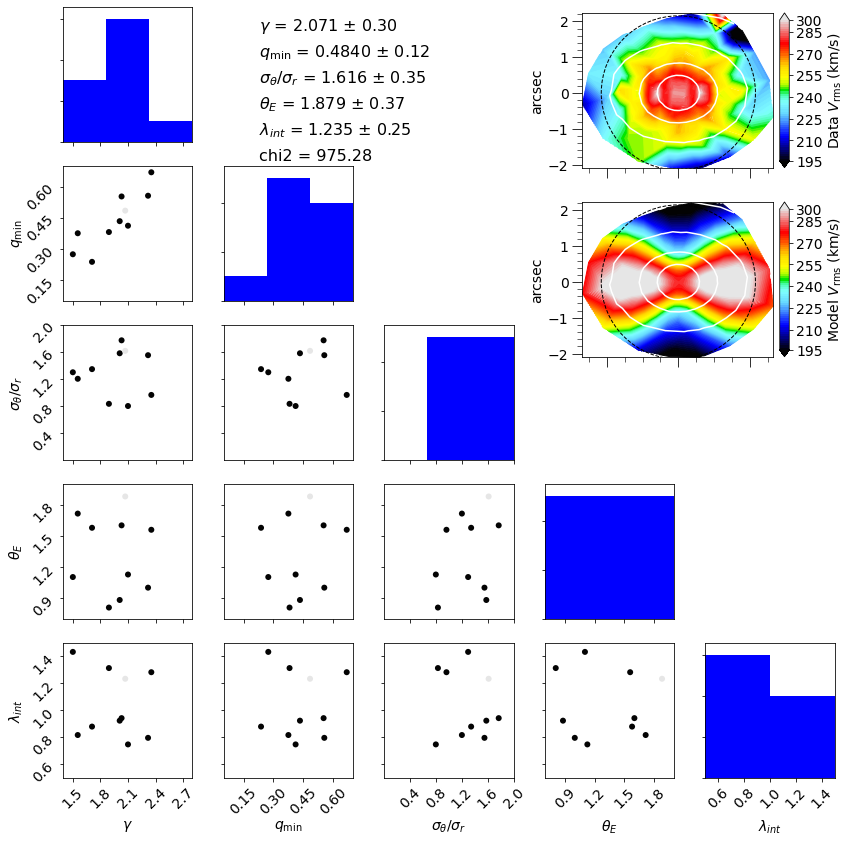

########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Beginning cyl aligned models.
Commencing JAM routine with model power_law, anisotropy const, geometry axi, and alignment cyl... lensprior... number of steps 1
Current date and time is 2023_10_02-03_27_19_PM
JAMMING.
########################################################
p0 [2.18  0.4   0.9   1.509 1.   ]
bounds [[1.4   0.051 0.01  0.7   0.5  ]
 [2.8   1.    1.    2.    1.5  ]]
sigpar [0.04 0.2  0.2  0.02 0.2 ]
prior_type ['gaussian', 'uniform', 'uniform', 'gaussian', 'uniform']
bounds in jam [[1.4   0.051 0.01  0.7   0.5  ]
 [2.8   0.7   1.    2.    1.5  ]]
Files in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_10_02_v1_15_power_law_const_axi_cyl_lensprior_0.3/ will be overwritten.

Outputs to  /data/raw_data/KE

100%|██████████| 1/1 [00:18<00:00, 18.28s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

n accepted unique parameters 10
power_law
JAMMING the best fit model

Best-fitting parameters and 1sigma errors:
   $\gamma$ = 2.583 +/- 0.35
   $q_{\rm min}$ = 0.07482 +/- 0.070
   $\sigma_z/\sigma_R$ = 0.9293 +/- 0.10
   $\theta_E$ = 1.557 +/- 0.17
   $\lambda_{int}$ = 0.6178 +/- 0.21


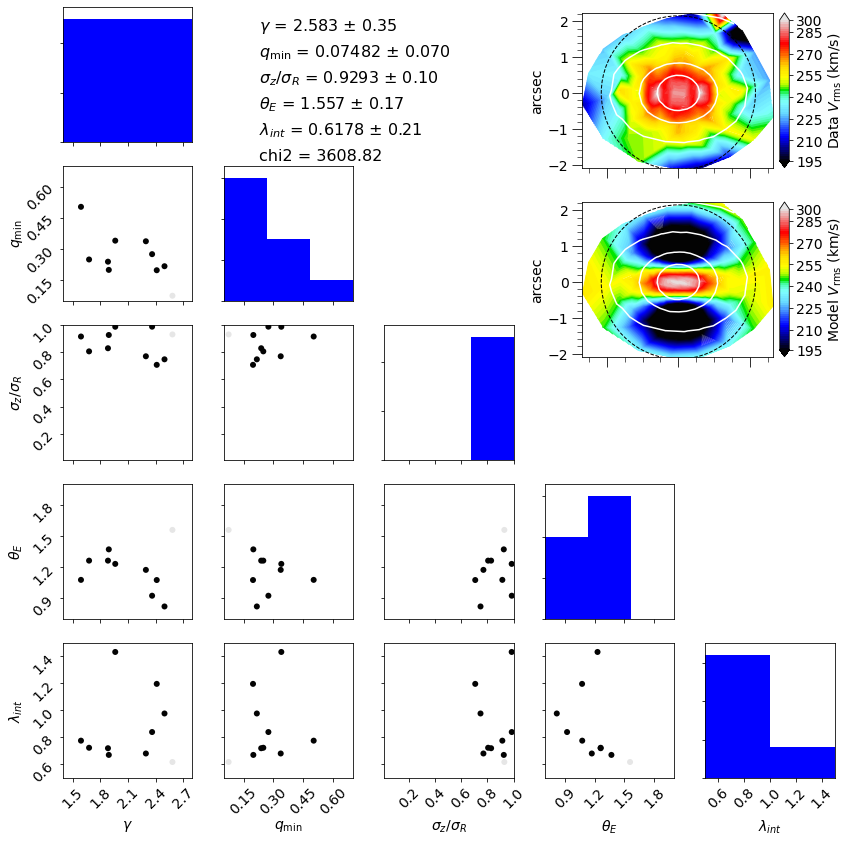

########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Beginning sph geometry models.
Beginning sph aligned models.
Commencing JAM routine with model power_law, anisotropy const, geometry sph, and alignment sph... lensprior... number of steps 1
Current date and time is 2023_10_02-03_28_26_PM
JAMMING.
########################################################
p0 [2.18  0.9   1.509 1.   ]
bounds [[1.4  0.01 0.7  0.5 ]
 [2.8  1.   2.   1.5 ]]
sigpar [0.04 0.2  0.02 0.2 ]
prior_type ['gaussian' 'uniform' 'gaussian' 'uniform']
bounds in jam [[1.4  0.01 0.7  0.5 ]
 [2.8  2.   2.   1.5 ]]

Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0037-0942/target_sn_15/SDSSJ0037-0942_model_2023_10_02_v1_15_power_law_const_sph_sph_lensprior_0.3/

Started Emcee please wait...
Progress is printed periodically


100%|██████████| 1/1 [00:18<00:00, 18.10s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

n accepted unique parameters 10
power_law
JAMMING the best fit model
False

Best-fitting parameters and 1sigma errors:
   $\gamma$ = 1.711 +/- 0.25
   $\sigma_{\theta}/\sigma_r$ = 0.5856 +/- 0.50
   $\theta_E$ = 1.341 +/- 0.39
   $\lambda_{int}$ = 0.9704 +/- 0.35


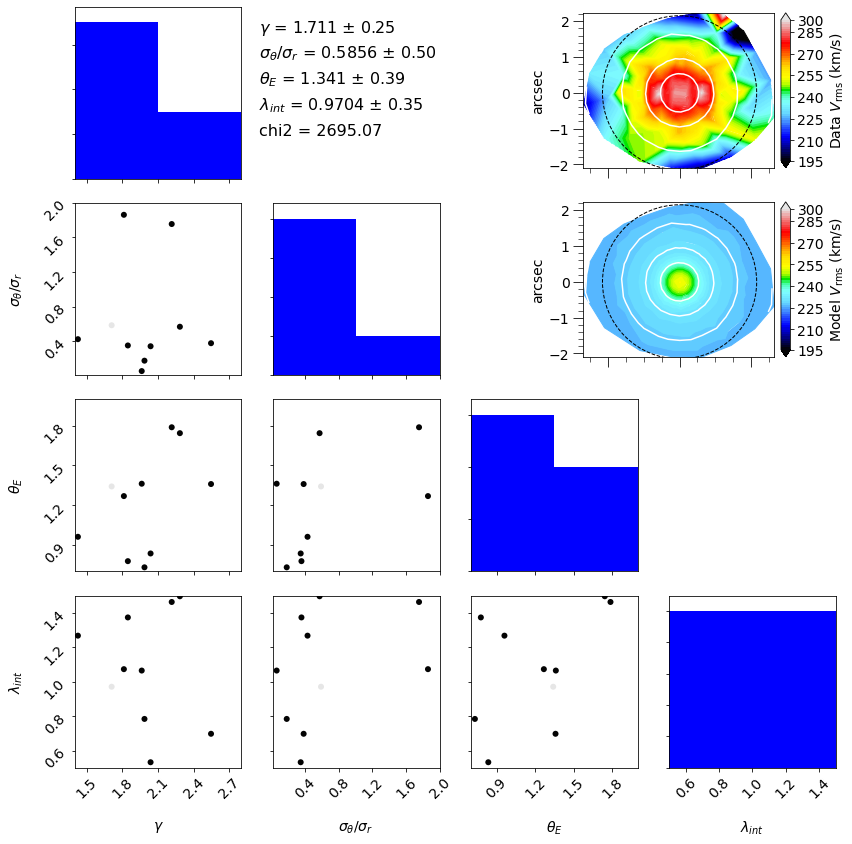

########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
No cylindrical alignment in spherical geometry.
Jamming object SDSSJ1112+0826.
Brace for jamming.
########################################################
Designated target is S/N 15.
Beginning power_law models.
Beginning const models.
Beginning axi geometry models.
Beginning sph aligned models.
Commencing JAM routine with model power_law, anisotropy const, geometry axi, and alignment sph... lensprior... number of steps 1
Current date and time is 2023_10_02-03_29_32_PM
JAMMING.
########################################################
p0 [2.21  0.4   0.9   1.421 1.   ]
bounds [[1.4   0.051 0.01  0.7   0.5  ]
 [2.8   1.    1.    2.    1.5  ]]
sigpar [0.06  0.2   0.2   0.015 0.2  ]
prior_type ['gaussian', 'uniform', 'uniform', 'gaussian', 'uniform']
bounds in jam [[1.4   0.051 0.01  

100%|██████████| 1/1 [00:10<00:00, 10.36s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

n accepted unique parameters 10
power_law
JAMMING the best fit model

Best-fitting parameters and 1sigma errors:
   $\gamma$ = 2.083 +/- 0.33
   $q_{\rm min}$ = 0.1176 +/- 0.13
   $\sigma_{\theta}/\sigma_r$ = 0.6666 +/- 0.33
   $\theta_E$ = 1.592 +/- 0.19
   $\lambda_{int}$ = 1.159 +/- 0.15


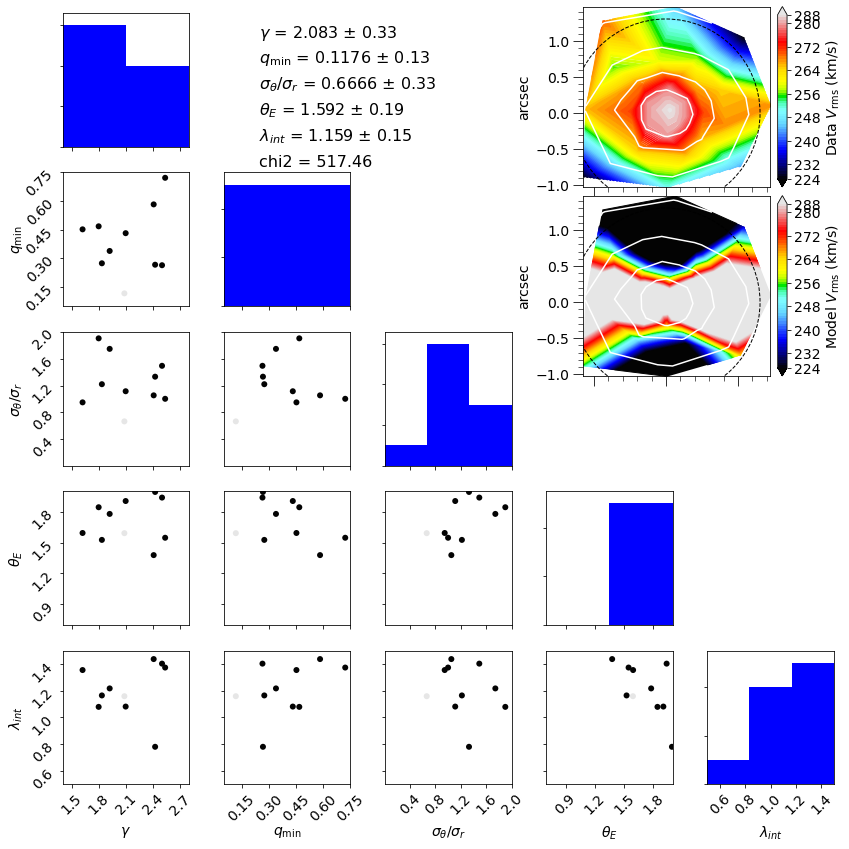

########################################################
We've been... JAMMED! On to the next?
########################################################
########################################################
Beginning cyl aligned models.
Commencing JAM routine with model power_law, anisotropy const, geometry axi, and alignment cyl... lensprior... number of steps 1
Current date and time is 2023_10_02-03_30_25_PM
JAMMING.
########################################################
p0 [2.21  0.4   0.9   1.421 1.   ]
bounds [[1.4   0.051 0.01  0.7   0.5  ]
 [2.8   1.    1.    2.    1.5  ]]
sigpar [0.06  0.2   0.2   0.015 0.2  ]
prior_type ['gaussian', 'uniform', 'uniform', 'gaussian', 'uniform']
bounds in jam [[1.4   0.051 0.01  0.7   0.5  ]
 [2.8   0.75  1.    2.    1.5  ]]
Files in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1112+0826/target_sn_15/SDSSJ1112+0826_model_2023_10_02_v1_15_power_law_const_axi_cyl_lensprior_0.3/ will be overwritten.

Outputs to  /data/raw_da

Traceback (most recent call last):
  File "/home/shawnknabel/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-517-184ee452642e>", line 65, in jam_lnprob
    plot=plot)
  File "<ipython-input-282-70c17b33573c>", line 74, in total_mass_mge
    surf_pot, sigma_pot, qobs_pot = power_law_mge(gamma, theta_E, q_mean, rbreak, lambda_int, rs_mst, zlens, zsource, plot)
  File "<ipython-input-280-87ba2a7b3030>", line 34, in power_law_mge
    m = mge_fit_1d(r, surf_mass_dens, ngauss=20, inner_slope=20, outer_slope=0, quiet=1, plot=plot) # this creates a circular gaussian with sigma=sigma_x (i.e. along the major axis)
  File "/home/shawnknabel/.local/lib/python3.7/site-packages/mgefit/mge_fit_1d.py", line 272, in __init__
    nprint=10, parinfo=parinfo, quiet=quiet)
  File "/home/shawnknabel/.local/lib/python3.7/site-packages/mgefit/cap_mpfit.py", line 1079, in __init__
    functkw=functkw, ifree=ifre

KeyboardInterrupt: 

In [521]:
# set mass model, anisotropy, and alignment
models = ['power_law','nfw']
anis = ['const','OM']
geoms = ['axi', 'sph']
aligns = ['sph', 'cyl']
lenspriors = ['lensprior','nolensprior']
#scale_radii = np.arange(0.1, 0.6, 0.1) # 10*reff to 50*reff
rs_mst = 0.3 # scale radius for mass sheet

# set nstep
nstep= 300
nwalkers= 16#32

print('Thank you for choosing MiseryBot 9.3.2, where you will hate everything and probably quit after a short while.')
print('...')
print('Please hold...')
print('...')
print('Ah yes, the JAM routine. This one is fun.')
print('...')
print('But where to start?')
print('...')

date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p")
print(f'Current date is {date_time}. Hopefully tomorrow will be better.')


print('########################################################')
print('########################################################')

for i, obj_name in enumerate(active_obj_names[1:]):
    
    print(f'Jamming object {obj_name}.')
    print('Brace for jamming.')

    print('########################################################') 
    
    for j, SN in enumerate([vorbin_SN_targets[1]]):
        
        print(f'Designated target is S/N {SN}.')
        
        for k, model in enumerate([models[0]]):
            
            print(f'Beginning {model} models.')
            
            for l, anisotropy in enumerate([anis[0]]):
                
                print(f'Beginning {anisotropy} models.')
                
                # skip the const models for J0029, 0037, 1112, 1204
                #if any(skip_models == i) and anisotropy=='const':
                #    print('Skipping constant anisotropy, completed on 09/11/23.')
                #    continue
                
                for w, geometry in enumerate(geoms):
                
                    print(f'Beginning {geometry} geometry models.')
                
                    for m, align in enumerate(aligns):
                        
                        # skip cylindrical when using spherical geometry
                        if (geometry=='sph') & (align=='cyl'):
                            print('No cylindrical alignment in spherical geometry.')
                            continue
                            
                        if (anisotropy=='OM') & (align=='cyl'):
                            print('No OM for cylindrical alignment.')
                            continue

                        print(f'Beginning {align} aligned models.')
                        

                        for n, lensprior in enumerate([lenspriors[0]]):

                            print(f'Commencing JAM routine with model {model}, anisotropy {anisotropy}, geometry {geometry}, and alignment {align}... {lensprior}... number of steps {nstep}')
                            print(f'Current date and time is {tick()}')
                            print('JAMMING.')
                            print('########################################################') 

                            if model=='power_law' and anisotropy=='const':
                                p0 = np.copy(p0_pow_const)
                                bounds = np.copy(bounds_pow_const)
                                sigpar = np.copy(sigpar_pow_const)
                                # take lens priors lensprior = 'lensprior'
                                if lensprior=='lensprior':
                                    if obj_name == 'SDSSJ1538+5817':
                                        print('SDSSJ1538+5817 does not have lens prior for now.')
                                        continue
                                    else:
                                        # update lensing priors
                                        lens_model = lens_models[lens_models['obj_name']==obj_name]
                                        p0[0] = lens_model['gamma'].iloc[0] #power_law_slopes.iloc[obj_name].iloc[i, 1]
                                        sigpar[0] = lens_model['dgamma'].iloc[0]
                                        p0[3] = lens_model['theta_E'].iloc[0]
                                        sigpar[3] = lens_model['dtheta_E'].iloc[0]
                                        prior_type=['gaussian','uniform','uniform','gaussian','uniform']
                                else:
                                    prior_type = np.copy(prior_type_uniform)

                            if model=='power_law' and anisotropy=='OM':
                                p0 = np.copy(p0_pow_om)
                                bounds = np.copy(bounds_pow_om)
                                sigpar = np.copy(sigpar_pow_om)
                                # take lens priors lensprior = 'lensprior'
                                if lensprior=='lensprior':
                                    if obj_name == 'SDSSJ1538+5817':
                                        print('SDSSJ1538+5817 does not have lens prior for now.')
                                        continue
                                    else:
                                        # update lensing priors
                                        lens_model = lens_models[lens_models['obj_name']==obj_name]
                                        p0[0] = lens_model['gamma'].iloc[0] #power_law_slopes.iloc[obj_name].iloc[i, 1]
                                        sigpar[0] = lens_model['dgamma'].iloc[0]
                                        p0[3] = lens_model['theta_E'].iloc[0]
                                        sigpar[3] = lens_model['dtheta_E'].iloc[0]
                                        prior_type=['gaussian','uniform','uniform','gaussian','uniform']
                                else:
                                    prior_type = np.copy(prior_type_uniform)

                            if model=='nfw' and anisotropy=='const':
                                p0 = np.copy(p0_nfw_const)
                                bounds = np.copy(bounds_nfw_const)
                                sigpar = np.copy(sigpar_nfw_const)
                                prior_type = np.copy(prior_type_uniform)
                                if lensprior=='lensprior':
                                    print('No lens prior for NFW.')
                                    print('########################################################') 
                                    print("No JAM! On to the next?")
                                    print('########################################################') 
                                    print('########################################################')
                                    continue

                            if model=='nfw' and anisotropy=='OM':
                                p0 = np.copy(p0_nfw_om)
                                bounds = np.copy(bounds_nfw_om)
                                sigpar = np.copy(sigpar_nfw_om)
                                prior_type = np.copy(prior_type_uniform)
                                if lensprior=='lensprior':
                                    print('No lens prior for NFW.')
                                    print('########################################################') 
                                    print("No JAM! On to the next?")
                                    print('########################################################') 
                                    print('########################################################')
                                    continue
                                    
                            if geometry=='sph':
                                # remove q parameter at index 1
                                p0 = np.delete(p0, 1)
                                bounds = np.delete(bounds, 1, axis=1)
                                sigpar = np.delete(sigpar, 1)
                                prior_type = np.delete(prior_type, 1)
                                    
                            print('p0', p0)
                            print('bounds', bounds)
                            print('sigpar', sigpar)
                            print('prior_type', prior_type)

                            # sampler args for emcee
                            ndim = len(p0)
                            sampler_args = [nstep, nwalkers, ndim] # 10 walkers

                            space_jam (obj_name, SN, model, anisotropy, geometry, align,  \
                                       sampler='emcee', sampler_args=sampler_args, \
                                       rs_mst=rs_mst, \
                                       p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, \
                                       date_time=date_time, overwrite=True, run_id=1)

                            print('########################################################') 
                            print("We've been... JAMMED! On to the next?")
                            print('########################################################') 
                            print('########################################################') 

print(f'Okay, all done as of {tick()}. Thank you for using MiseryBot 9.1.3. We deprecated while you were away. Hope you data is not corrupted.')


__________________
__________________

# BREAK
__________________
__________________